<a href="https://colab.research.google.com/github/WiemHAD/D-posit/blob/main/Projet_E1_Wiem_MOOTAMED_HADDAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attribute Information:
### Bank client data:
* Age (numeric)
* Job : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
* Marital : marital status (categorical: 'divorced', 'married', 'single', 'unknown' ; note: 'divorced' means divorced or widowed)
* Education (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
* Default: has credit in default? (categorical: 'no', 'yes', 'unknown')
* Housing: has housing loan? (categorical: 'no', 'yes', 'unknown')
* Loan: has personal loan? (categorical: 'no', 'yes', 'unknown')

### Related with the last contact of the current campaign:
* Contact: contact communication type (categorical:'cellular','telephone')
* Month: last contact month of year (categorical: 'jan', 'feb', 'mar',…, 'nov', 'dec')
* Dayofweek: last contact day of the week (categorical:'mon','tue','wed','thu','fri')
* Duration: last contact duration, in seconds (numeric). 

#### Important
 **note:**  this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known.
Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### Other attributes:
* Campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* Pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* Previous: number of contacts performed before this campaign and for this client (numeric)
* Poutcome: outcome of the previous marketing campaign (categorical:'failure','nonexistent','success')

### Social and economic context attributes
* Emp.var.rate: employment variation rate - quarterly indicator (numeric)
* Cons.price.idx: consumer price index - monthly indicator (numeric)
* Cons.conf.idx: consumer confidence index - monthly indicator (numeric)
* Euribor3m: euribor 3 month rate - daily indicator (numeric)
* Nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
* y - has the client subscribed a term deposit? (binary: 'yes', 'no')

## Import librairies

In [267]:
from google.colab import drive


import random
import pandas as pd
import numpy as np
import math
import statistics
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score
from sklearn.metrics import plot_roc_curve


## Mount Drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## Import Data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/DATA/data_banking/banking.csv', sep=';')
df.rename(columns = {'emp.var.rate':'emp_var_rate', 'cons.price.idx':'cons_price_idx','cons.conf.idx':'cons_conf_idx', 'nr.employed':'nr_employed' }, inplace = True)

## Features Comprehension

In [5]:
#features comprehension 
cat_col=[]
cols = df.columns

for col in cols:
  if df[col].dtypes == 'object':
    cat_col.append(col)
    print(col)
    print(df[col].unique())
    print(df[col].value_counts())
    print('***'*20)

job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
************************************************************
marital
['married' 'single' 'divorced' 'unknown']
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
************************************************************
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basi

In [6]:
def get_df_infos(df_):
  """ Detect NaN """

    df_info = pd.DataFrame(columns={"column", "NaN", "NaN %"})

    for index, value in df_.isna().sum().iteritems():
        df_temp = pd.DataFrame({"column" : index, "NaN" : [value], "NaN %" : round(value*100 /len(df_), 2)})
        df_info = pd.concat([df_info, df_temp], ignore_index=True)
        df_info.sort_values(by="NaN", ascending=False, inplace=True)

    int_ = df_.select_dtypes(include=['int64']).columns.to_list()
    float_ = df_.select_dtypes(include=['float64']).columns.to_list()
    object_ = df_.select_dtypes(include=['object']).columns.to_list()

    print(f"Int64 : {', '.join(int_)}")
    print(f"\nFloat64 : {', '.join(float_)}")
    print(f"\nObject : {', '.join(object_)}\n") 
    
    print("Total detected columns =",len(int_) + len(float_) + len(object_))
    print("\nshape =", df_.shape)
    print("\nshape without NaNs =", df_.dropna().shape)

    print("\n\n", df_info)

In [7]:
get_df_infos(df)

Int64 : age, duration, campaign, pdays, previous

Float64 : emp_var_rate, cons_price_idx, cons_conf_idx, euribor3m, nr_employed

Object : job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome, y

Total detected columns = 21

shape = (41188, 21)

shape without NaNs = (41188, 21)


     NaN %          column NaN
0     0.0             age   0
11    0.0             job   0
19    0.0     nr_employed   0
18    0.0   cons_conf_idx   0
17    0.0    emp_var_rate   0
16    0.0        poutcome   0
15    0.0        previous   0
14    0.0           pdays   0
13    0.0        campaign   0
12    0.0        duration   0
10    0.0     day_of_week   0
1     0.0           month   0
9     0.0         contact   0
8     0.0            loan   0
7     0.0         housing   0
6     0.0         default   0
5     0.0       education   0
4     0.0         marital   0
3     0.0  cons_price_idx   0
2     0.0       euribor3m   0
20    0.0               y   0


## Data Vizualisation

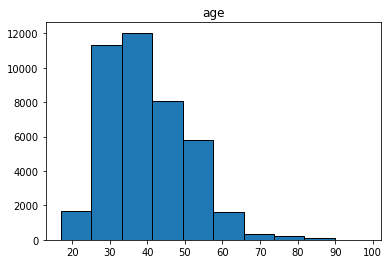

<Figure size 576x432 with 0 Axes>

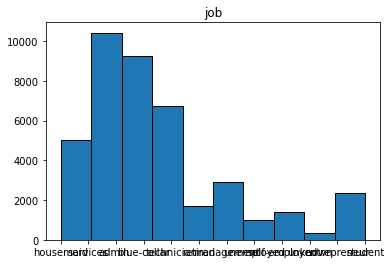

<Figure size 576x432 with 0 Axes>

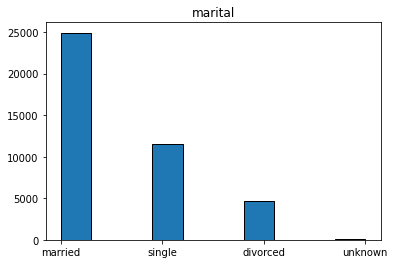

<Figure size 576x432 with 0 Axes>

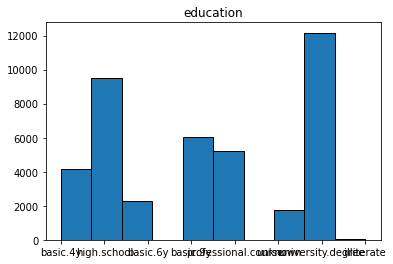

<Figure size 576x432 with 0 Axes>

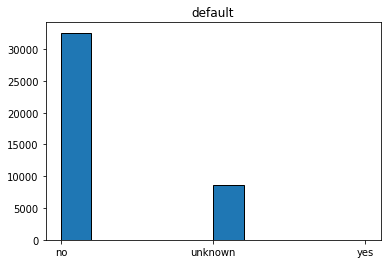

<Figure size 576x432 with 0 Axes>

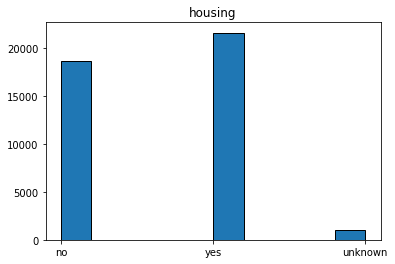

<Figure size 576x432 with 0 Axes>

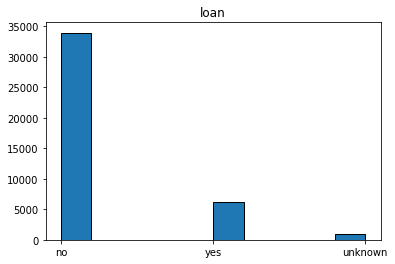

<Figure size 576x432 with 0 Axes>

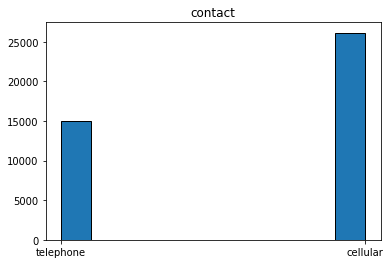

<Figure size 576x432 with 0 Axes>

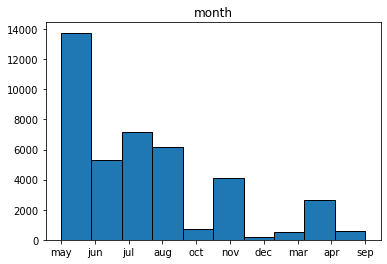

<Figure size 576x432 with 0 Axes>

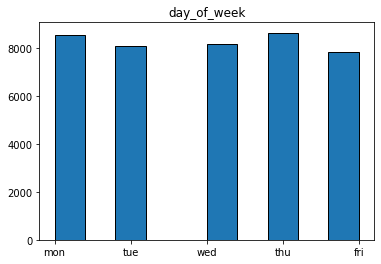

<Figure size 576x432 with 0 Axes>

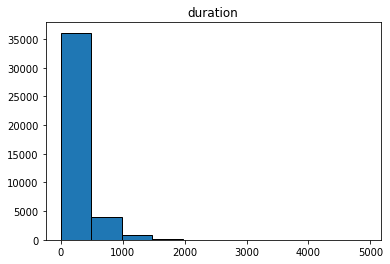

<Figure size 576x432 with 0 Axes>

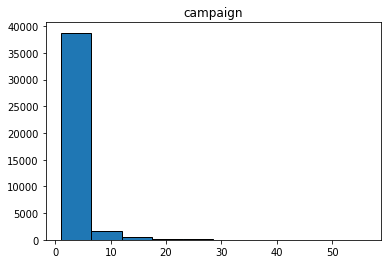

<Figure size 576x432 with 0 Axes>

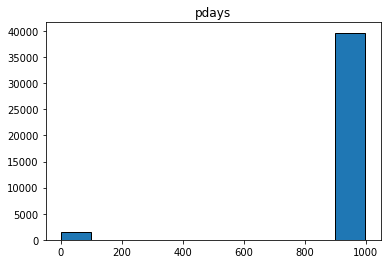

<Figure size 576x432 with 0 Axes>

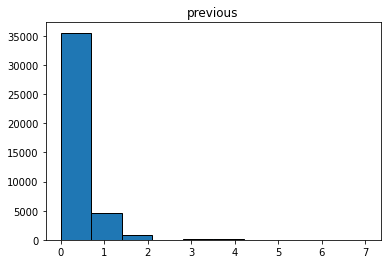

<Figure size 576x432 with 0 Axes>

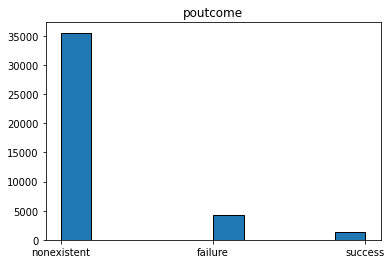

<Figure size 576x432 with 0 Axes>

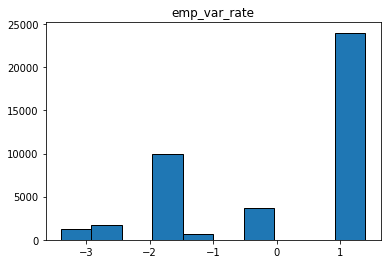

<Figure size 576x432 with 0 Axes>

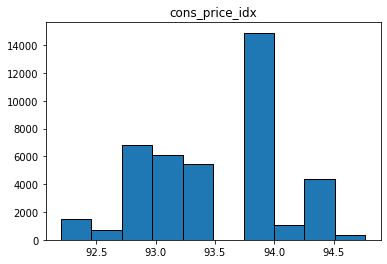

<Figure size 576x432 with 0 Axes>

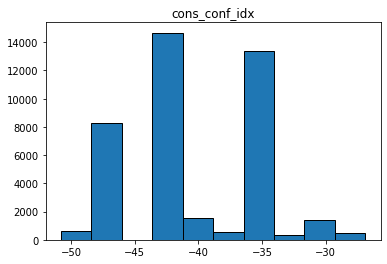

<Figure size 576x432 with 0 Axes>

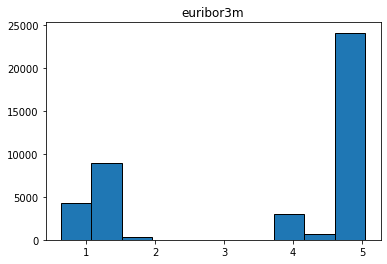

<Figure size 576x432 with 0 Axes>

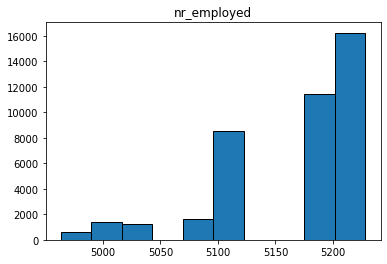

<Figure size 576x432 with 0 Axes>

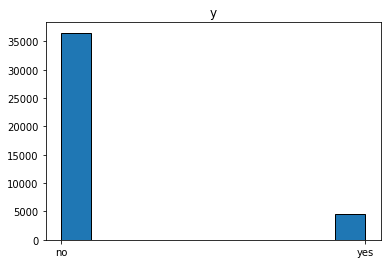

<Figure size 576x432 with 0 Axes>

In [8]:
from matplotlib.pyplot import figure

for n in cols:
  plt.hist(df[n], edgecolor='black')
  plt.title(n)
  figure(figsize=(8, 6))
  plt.show()

Text(0.5, 1.05, 'Pearson correlation of Features')

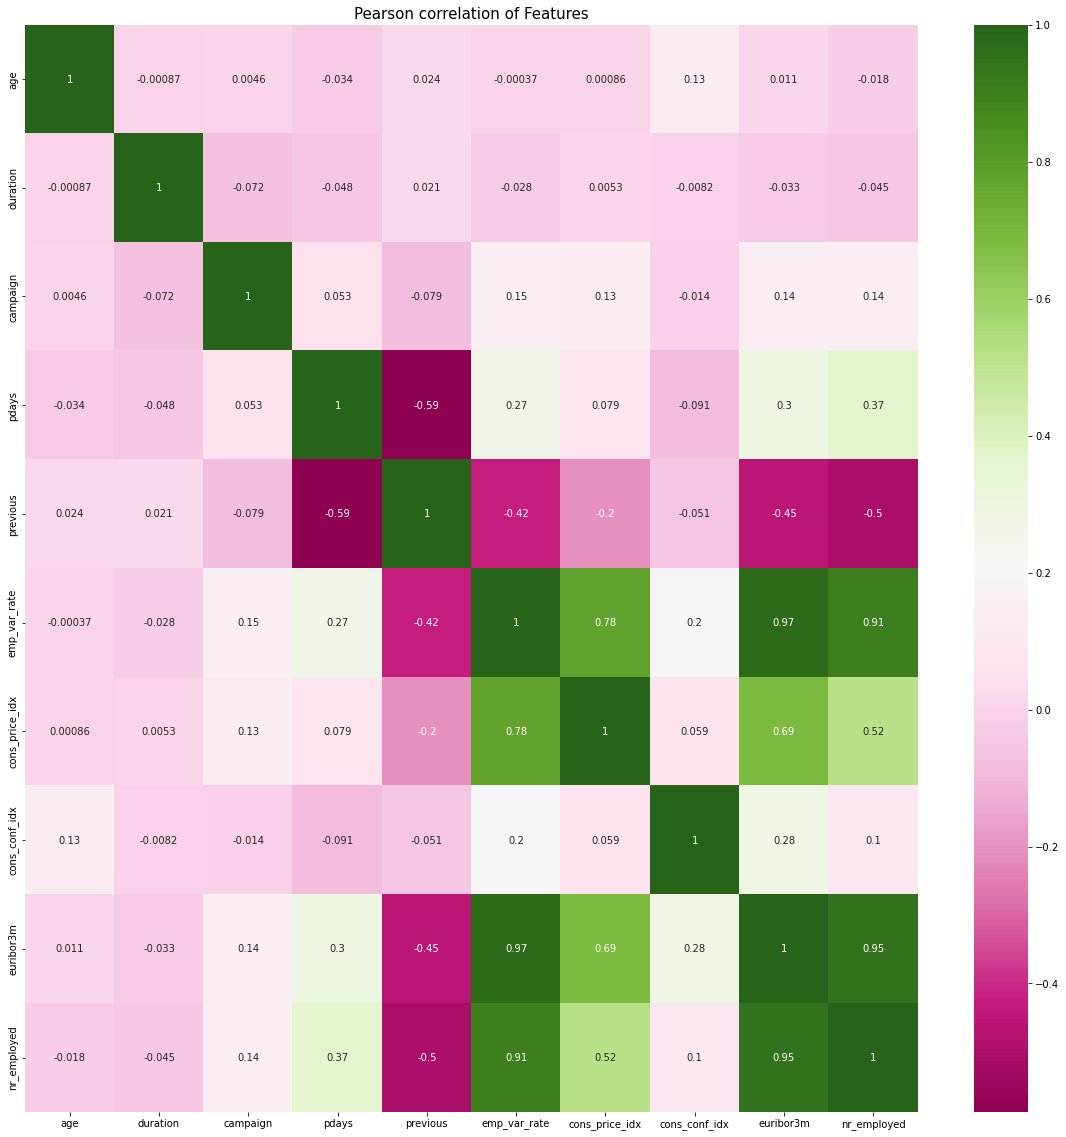

In [9]:
corr = df.corr()

f, ax = plt.subplots(figsize=(20,20))

sns.heatmap(corr, ax=ax, annot=True, cmap="PiYG" )

plt.title("Pearson correlation of Features", y=1.05, size=15)

## Target and Features


In [15]:
#drop unused features
new_df = df.drop(["cons_price_idx","emp_var_rate","nr_employed", "poutcome", "pdays"],axis=1)

In [20]:
X = new_df.drop('y',axis=1)
Y = new_df['y']

## Split Data Into Train and Test

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## Encod categorical features

In [17]:
encoder = LabelEncoder()

In [18]:
encoder = LabelEncoder()

new_df["job"] = encoder.fit_transform(new_df["job"])
new_df["marital"] = encoder.fit_transform(new_df["marital"])
new_df["education"] = encoder.fit_transform(new_df["education"])
new_df["default"] = encoder.fit_transform(new_df["default"])
new_df["housing"] = encoder.fit_transform(new_df["housing"])
new_df["loan"] = encoder.fit_transform(new_df["loan"])
new_df["contact"] = encoder.fit_transform(new_df["contact"])
new_df["month"] = encoder.fit_transform(new_df["month"])
new_df["day_of_week"] = encoder.fit_transform(new_df["day_of_week"])
new_df["y"] = encoder.fit_transform(new_df["y"])

## Scale continues variables

In [33]:
scaler = StandardScaler()
new_df[["cons_conf_idx"]] = scaler.fit_transform(new_df[["cons_conf_idx"]])
new_df[["euribor3m"]] = scaler.fit_transform(new_df[["euribor3m"]])

## PCA

In [37]:
pca = PCA(n_components=15, random_state=100)
pca.fit(X)
X1_pca = pca.transform(X)
pca.explained_variance_ratio_*100

array([9.97507406e+01, 1.61996974e-01, 3.17802892e-02, 1.92213828e-02,
       1.15969112e-02, 8.13278563e-03, 6.35857632e-03, 3.89900581e-03,
       2.86857348e-03, 1.43478202e-03, 7.73280217e-04, 4.58119371e-04,
       2.84635811e-04, 2.39365181e-04, 2.14728582e-04])

In [40]:
np.cumsum(pca.explained_variance_ratio_*100)

array([ 99.75074059,  99.91273756,  99.94451785,  99.96373924,
        99.97533615,  99.98346893,  99.98982751,  99.99372652,
        99.99659509,  99.99802987,  99.99880315,  99.99926127,
        99.99954591,  99.99978527, 100.        ])

Text(0, 0.5, 'Second principal component')

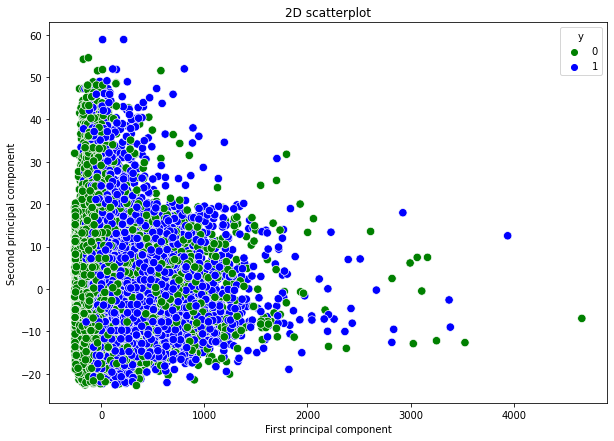

In [42]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=X1_pca[:,0], y=X1_pca[:,1], s=70, hue= new_df.y, palette=['green','blue'])
plt.title("2D scatterplot")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

# models

#### 1. XGBOOST Classifier



In [44]:
import xgboost as xgb

steps1 = [('XGBOOST', xgb.XGBClassifier())]
pipe1 = Pipeline(steps1) # define the pipeline object.
pipe1 = pipe1.fit(X_train, y_train)
score_XGB = pipe1.score(X_test, y_test)
y_pred_XGB = pipe1.predict(X_test)

Testing score:  0.9121145909201263


#### 2. KNN Classifier

In [45]:
steps2 = [('KNN', KNeighborsClassifier(n_neighbors=5))]
pipe2 = Pipeline(steps2) # define the pipeline object.
pipe2 = pipe2.fit(X_train, y_train)
y_pred_KNN = pipe2.predict(X_test)

#### 3. SGD Classifier

In [47]:
steps3 = [('SGD', SGDClassifier())]
pipe3 = Pipeline(steps3) # define the pipeline object.
pipe3 = pipe3.fit(X_train, y_train)
y_pred_SGD = pipe3.predict(X_test)

#### 4.Extra Tree Classifier




In [48]:
steps5 = [('ExtraTree Classifier', ExtraTreesClassifier())]                           
pipe5 = Pipeline(steps5) # define the pipeline object.
pipe5 = pipe5.fit(X_train, y_train)
score_EXT = pipe5.score(X_test, y_test)
y_pred_EXT = pipe5.predict(X_test)

#### 5. Random Forest

In [49]:
steps6 = [('Random Forest', RandomForestClassifier())]                                           
pipe6 = Pipeline(steps6) # define the pipeline object.
pipe6 = pipe6.fit(X_train, y_train)
y_pred_RF = pipe6.predict(X_test)

Testing score:  0.9104151493080845


## metrics

In [53]:
def metrics(pipe1, pipe2, pipe3, pipe5, pipe6):
  metrics = pd.DataFrame(columns =["testing_score", "F1_score", "recall", "precision", "CM_XGB"])
  list_testing_score=[]
  list_f1_score=[]
  list_recall=[]
  list_precision=[]
  list_CM=[]
  models_name = [pipe1, pipe2, pipe3, pipe5, pipe6]

  for model in models_name: 

    y_pred = model.predict(X_test)

    F1_score = round(f1_score(y_true=y_test, y_pred=y_pred),4)
    list_f1_score.append(F1_score)

    recall = round(recall_score(y_true=y_test, y_pred=y_pred),4)
    list_recall.append(recall)

    precision = round(precision_score(y_true=y_test, y_pred=y_pred),4)
    list_precision.append(precision)

  metrics = pd.DataFrame(
      {'F1_score': list_f1_score, 'recall': list_recall, 'precision': list_precision},
      index=["XGB", "KNN", "SGD", "EXT", "RF"]
      )
  return metrics

In [52]:
metrics(pipe1, pipe2, pipe3, pipe5, pipe6)

,F1_score,recall,precision
XGB,0.6302,0.6606,0.6025
KNN,0.3537,0.3501,0.3574
SGD,0.0374,0.0193,0.6207
EXT,0.4854,0.3822,0.6648
RF,0.5778,0.5407,0.6204


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


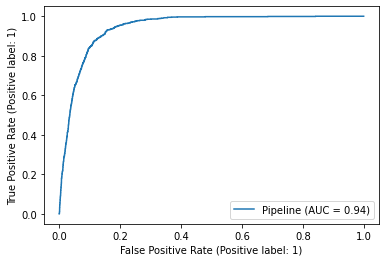

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


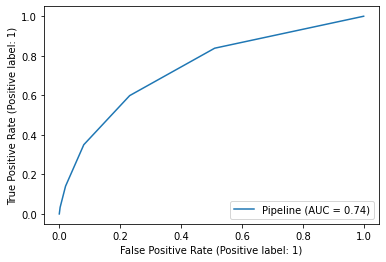

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


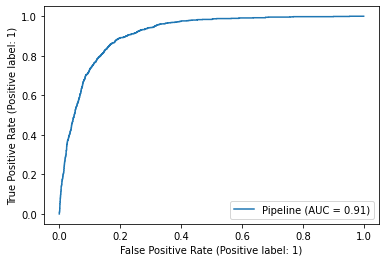

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


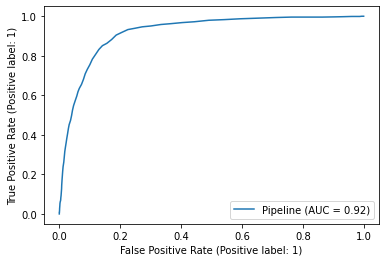

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


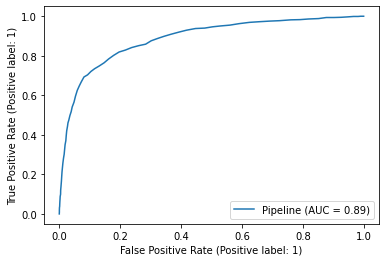

In [58]:
models_name = [pipe1, pipe2, pipe3, pipe5, pipe6]
for model in models_name: 
  plot_roc_curve(model, X_test, y_test)
  plt.show()

In [60]:
  for i in models_name:
    print("Classification report", i)
    y_pred = i.predict(X_test)
    print(classification_report(y_test, y_pred))

Classification report Pipeline(steps=[('XGBOOST', XGBClassifier())])
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7304
           1       0.60      0.66      0.63       934

    accuracy                           0.91      8238
   macro avg       0.78      0.80      0.79      8238
weighted avg       0.92      0.91      0.91      8238

Classification report Pipeline(steps=[('KNN', KNeighborsClassifier())])
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7304
           1       0.36      0.35      0.35       934

    accuracy                           0.85      8238
   macro avg       0.64      0.63      0.64      8238
weighted avg       0.85      0.85      0.85      8238

Classification report Pipeline(steps=[('SGD', SGDClassifier())])
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7304
           1       0.62      0.

### Random Forest and XGBoost are best models in this case. But metrics are not good enough to make prediction. In order to improve results, Let's try Grid Search and change some hyperparametrs

## Grid Search

In [62]:
from datetime import datetime

def timer(start_time=None):

    if not start_time:

        start_time = datetime.now()

        return start_time

    elif start_time:

        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)

        tmin, tsec = divmod(temp_sec, 60)

        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [86]:
#XGBOOST with Grid search: 

params_XGB= {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
        }

model_XGB = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42)

clf_XGB = GridSearchCV(model_XGB, param_grid=params_XGB)
start_time = timer(None)
clf_XGB.fit(X_train, y_train)
timer(start_time)


 Time taken: 0 hours 16 minutes and 58.66 seconds.


In [87]:
best_XGB= clf_XGB.best_estimator_

In [88]:
y_pred_XGB = best_XGB.predict(X_test)

In [90]:
print("F1 score XGB={}".format(f1_score(y_true=y_test, y_pred=y_pred_XGB)))
print("Recall XGB ={}".format(recall_score(y_true=y_test, y_pred=y_pred_XGB)))
print("Precision XGB = {}".format(precision_score(y_true=y_test, y_pred=y_pred_XGB)))

F1 score XGB=0.5994805194805195
Recall XGB =0.6177730192719486
Precision XGB = 0.5822401614530777


In [67]:
#Random Forest Classifier with grid search: 
params_RF = {
    'n_estimators': [600, 700, 800], 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [20,40,60]
} 

model_RF = RandomForestClassifier()

clf_RF = GridSearchCV(model_RF, param_grid=params_RF)
start_time = timer(None)
clf_RF.fit(X_train, y_train)
timer(start_time)


 Time taken: 0 hours 36 minutes and 7.67 seconds.


In [68]:
y_pred_RF = clf_RF.predict(X_test)

In [69]:
print("F1 score RF={}".format(f1_score(y_true=y_test, y_pred=y_pred_RF)))
print("Recall XGB ={}".format(recall_score(y_true=y_test, y_pred=y_pred_RF)))
print("Precision XGB = {}".format(precision_score(y_true=y_test, y_pred=y_pred_RF)))

F1 score RF=0.5935190449118818
Recall XGB =0.5588865096359743
Precision XGB = 0.6327272727272727


# Data Augmentation with Auto Encoder

###manual split

In [91]:
#split le data set selon les classes 0 et 1 de y
df0 = new_df.loc[new_df['y']==0]
df1 = new_df.loc[new_df['y']==1]

In [92]:
print("df0.shape=",df0.shape)
print("df1.shape=",df1.shape)

df0.shape= (36548, 16)
df1.shape= (4640, 16)


In [93]:
#split chaque classe en features et target
X0 = df0.drop(("y"), axis=1)
X1 = df1.drop(("y"), axis=1)
Y0 = df0["y"]
Y1=df1["y"]

In [94]:
#split class 0 data into train and test
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0,Y0,test_size = 0.063)

In [95]:
print("X0 train shape=",X0_train.shape, "Y0 train shape=", Y0_train.shape)
print("X0 test shape=",X0_test.shape, "Y0 test shape=", Y0_test.shape)

X0 train shape= (34245, 15) Y0 train shape= (34245,)
X0 test shape= (2303, 15) Y0 test shape= (2303,)


In [96]:
#split class 1 data into train and test
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1,train_size = 0.5)

In [97]:
print("X1 train shape=",X1_train.shape, "Y1 train shape=", Y1_train.shape)
print("X1 test shape=",X1_test.shape, "Y1 test shape=", Y1_test.shape)

X1 train shape= (2320, 15) Y1 train shape= (2320,)
X1 test shape= (2320, 15) Y1 test shape= (2320,)


In [98]:
#gather 2 classes of dataset X test et Y_test
X_test = pd.concat([X1_test, X0_test])
Y_test = pd.concat([Y1_test, Y0_test])

#gather 2 classes of les features et le target
data_test = X_test.join(Y_test)
shuff_data_test = shuffle(data_test)

#melange indexes of the dataset
X_test_shuff = shuff_data_test.drop(('y'), axis=1)
Y_test_shuff = shuff_data_test['y']

In [99]:
print("X test shape ={}".format(X_test.shape))
print("X train de la classe 0 shape ={}".format(X0_train.shape))
print("X train de la classe 1 shape ={}" .format(X1_train.shape))


X test shape =(4623, 15)
X train de la classe 0 shape =(34245, 15)
X train de la classe 1 shape =(2320, 15)


### Data Augmentation

In [100]:
!pip install mlprep-ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import mlprepare as mlp

In [102]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, dataset):
        self.x = dataset.values
        self.x = torch.from_numpy(self.x).to(torch.float)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

traindata_set=DataBuilder(X_train)
testdata_set=DataBuilder(X_test)

trainloader=DataLoader(dataset=traindata_set,batch_size=1024)
testloader=DataLoader(dataset=testdata_set,batch_size=1024)

In [103]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return loss_MSE + loss_KLD

class Autoencoder(nn.Module):
    def __init__(self,D_in=None,H=50,H2=12,latent_dim=3):

        if D_in==None:
            raise ValueError('You need to specify the Input shape.')
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        
        # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class AutoencoderModel:
    def __init__(self,trainloader,testloader,device,D_in,H=50,H2=12,latent_dim=3):
        self.trainloader=trainloader
        self.testloader=testloader
        self.device=device
        self.D_in=D_in
        self.H=H
        self.H2=H2
        self.latent_dim=latent_dim
        self.model=Autoencoder(D_in, H, H2).to(self.device)
        self.optimizer=optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_mse = customLoss()
    
    def train_model(self,epoch, verbose, interval):
        train_losses = []
        self.model.train()
        train_loss = 0
        for _, data in enumerate(self.trainloader):
            data = data.to(self.device)
            self.optimizer.zero_grad()
            recon_batch, mu, logvar = self.model(data)
            loss = self.loss_mse(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            self.optimizer.step()
        if verbose:
            if epoch % interval == 0:        
                print('====> Epoch: {} Average training loss: {:.4f}'.format(
                    epoch, train_loss / len(self.trainloader.dataset)))
                train_losses.append(train_loss / len(self.trainloader.dataset))

    def test_model(self, epoch, verbose, interval):
        test_losses = []
        with torch.no_grad():
            test_loss = 0
            for _, data in enumerate(self.testloader):
                data = data.to(self.device)
                self.optimizer.zero_grad()
                recon_batch, mu, logvar = self.model(data)
                loss = self.loss_mse(recon_batch, data, mu, logvar)
                test_loss += loss.item()
            if verbose:
                if epoch % interval == 0:        
                    print('====> Epoch: {} Average test loss: {:.4f}'.format(
                        epoch, test_loss / len(self.testloader.dataset)))
                test_losses.append(test_loss / len(self.testloader.dataset))

    def fit(self, epochs, verbose=True, interval=200):
        for epoch in range(1, epochs + 1):
            self.train_model(epoch, verbose, interval)
            self.test_model(epoch, verbose, interval)
        return self

    def predict(self, no_samples, target_class):
        with torch.no_grad():
            for batch_idx, data in enumerate(self.trainloader):
                data = data.to(self.device)
                self.optimizer.zero_grad()
                _, mu_, logvar_ = self.model(data)
                if batch_idx==0:
                    mu=mu_
                    logvar=logvar_
                else:
                    mu=torch.cat((mu, mu_), dim=0)
                    logvar=torch.cat((logvar, logvar_), dim=0)
        sigma = torch.exp(logvar/2)
        no_samples = no_samples
        q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
        z = q.rsample(sample_shape=torch.Size([no_samples]))
        with torch.no_grad():
            pred = self.model.decode(z).cpu().numpy()
        df_fake = pd.DataFrame(pred)
        df_fake['Class']=target_class
        return df_fake

In [104]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, dataset):
        self.x = dataset.values
        self.x = torch.from_numpy(self.x).to(torch.float)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

traindata_set=DataBuilder(X_train)
testdata_set=DataBuilder(X_test)

trainloader=DataLoader(dataset=traindata_set,batch_size=1024)
testloader=DataLoader(dataset=testdata_set,batch_size=1024)

In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D_in = traindata_set.x.shape[1]
H = 50
H2 = 12
autoenc_model = AutoencoderModel(trainloader, testloader, device, D_in, H, H2, latent_dim=3)

In [106]:
autoenc_model_fit = autoenc_model.fit(3000) 

====> Epoch: 200 Average training loss: 127923.3385
====> Epoch: 200 Average test loss: 263712.1679
====> Epoch: 400 Average training loss: 121083.0830
====> Epoch: 400 Average test loss: 254598.4132
====> Epoch: 600 Average training loss: 114503.3077
====> Epoch: 600 Average test loss: 245751.4350
====> Epoch: 800 Average training loss: 108175.4461
====> Epoch: 800 Average test loss: 237156.5434
====> Epoch: 1000 Average training loss: 102097.6124
====> Epoch: 1000 Average test loss: 228814.0216
====> Epoch: 1200 Average training loss: 96264.6776
====> Epoch: 1200 Average test loss: 220717.4034
====> Epoch: 1400 Average training loss: 90658.6407
====> Epoch: 1400 Average test loss: 212848.1380
====> Epoch: 1600 Average training loss: 85232.7778
====> Epoch: 1600 Average test loss: 205160.9712
====> Epoch: 1800 Average training loss: 79976.7573
====> Epoch: 1800 Average test loss: 197645.9944
====> Epoch: 2000 Average training loss: 74890.6648
====> Epoch: 2000 Average test loss: 19030

In [107]:
no_samples = X_train.shape[0]-X_train.shape[0]

In [108]:
X_train.shape[0]

32950

In [109]:
#create new data
fake_train_data = autoenc_model_fit.predict(no_samples= no_samples,target_class=1)
fake_train_data.columns =  new_df.columns

In [110]:
for col in new_df.columns:
  min_col = new_df[col].min()
  max_col = new_df[col].max()
  #print(col,  "\n min =", min_col, "\n max= ", max_col)

In [111]:
int_col = fake_train_data.drop(["cons_conf_idx", "euribor3m","y"], axis=1)

for col in int_col:
  fake_train_data[col] = fake_train_data[col].astype({col:int})
  for j in fake_train_data[col].index:
    fake_train_data[col][j] = math.ceil(fake_train_data[col][j])

In [112]:
fake_train_data["cons_conf_idx"] = round(fake_train_data["cons_conf_idx"],1)
fake_train_data["euribor3m"] = round(fake_train_data["euribor3m"],4)

In [113]:
fake_train_data.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,cons_conf_idx,euribor3m,y


In [114]:
#regrouper le 2 classes du train set (sans integrer les données créées)
X_train_no_aug = pd.concat([X1_train, X0_train])
Y_train_no_aug = pd.concat([Y1_train, Y0_train])

In [115]:
data_train = X_train_no_aug.join(Y_train_no_aug)
shuff_data_train = shuffle(data_train)

In [116]:
shuff_data_train["y"].value_counts()

0    34245
1     2320
Name: y, dtype: int64

In [117]:
fake_train_data["y"].value_counts()

Series([], Name: y, dtype: int64)

In [118]:
all_train_set = shuffle(pd.concat([shuff_data_train,fake_train_data]))

In [119]:
all_train_set.shape

(36565, 16)

In [120]:
X_train_aug = all_train_set.drop("y", axis=1)
Y_train_aug = all_train_set["y"]

##XGBoost with augmented data

In [121]:
model_XGB = xgb.XGBClassifier()
model_XGB.fit(X_train_aug, Y_train_aug)
y_pred_aug = model_XGB.predict(X_test_shuff)

In [122]:
print(confusion_matrix(Y_test_shuff, y_pred_aug))

[[2277   26]
 [1776  544]]


In [123]:
print(classification_report(Y_test_shuff, y_pred_aug))

              precision    recall  f1-score   support

           0       0.56      0.99      0.72      2303
           1       0.95      0.23      0.38      2320

    accuracy                           0.61      4623
   macro avg       0.76      0.61      0.55      4623
weighted avg       0.76      0.61      0.55      4623



In [124]:
F1_score_DA = round(f1_score(y_true=Y_test_shuff, y_pred=y_pred_aug),4)
recall_DA = round(recall_score(y_true=Y_test_shuff, y_pred=y_pred_aug),4)
precision_DA = round(precision_score(y_true=Y_test_shuff, y_pred=y_pred_aug),4)

In [125]:
print("\n F1 score= {} \n recall score= {} \n precision score= {}".format(F1_score_DA, recall_DA,precision_DA))


 F1 score= 0.3765 
 recall score= 0.2345 
 precision score= 0.9544


##Random Forest with augmented data

In [126]:
model_RF = RandomForestClassifier()
model_RF.fit(X_train_aug, Y_train_aug)
y_pred_aug2 = model_RF.predict(X_test_shuff)

In [127]:
print(confusion_matrix(Y_test_shuff, y_pred_aug2))

[[2268   35]
 [1759  561]]


In [128]:
print(classification_report(Y_test_shuff, y_pred_aug2))

              precision    recall  f1-score   support

           0       0.56      0.98      0.72      2303
           1       0.94      0.24      0.38      2320

    accuracy                           0.61      4623
   macro avg       0.75      0.61      0.55      4623
weighted avg       0.75      0.61      0.55      4623



In [129]:
y_pred_val = model_RF.predict(X_test)

In [130]:
F1_score_DA2 = round(f1_score(y_true=Y_test_shuff, y_pred=y_pred_aug2),4)
recall_DA2 = round(recall_score(y_true=Y_test_shuff, y_pred=y_pred_aug2),4)
precision_DA2 = round(precision_score(y_true=Y_test_shuff, y_pred=y_pred_aug2),4)

In [131]:
print("\n F1 score= {} \n recall score= {} \n precision score= {}".format(F1_score_DA2, recall_DA2,precision_DA2))


 F1 score= 0.3848 
 recall score= 0.2418 
 precision score= 0.9413


In [132]:
print(confusion_matrix(Y_test, y_pred_val))

[[2268   35]
 [1759  561]]


In [133]:
print(classification_report(Y_test, y_pred_val))

              precision    recall  f1-score   support

           0       0.56      0.98      0.72      2303
           1       0.94      0.24      0.38      2320

    accuracy                           0.61      4623
   macro avg       0.75      0.61      0.55      4623
weighted avg       0.75      0.61      0.55      4623



# Under Sampling

## 1st Test

In [135]:
df1 = new_df[new_df["y"]==1].reset_index(drop=True)
df1.shape

(4640, 16)

In [136]:
df0 = new_df[new_df["y"]==0].reset_index(drop=True)
df0.shape

(36548, 16)

In [137]:
wanted_indices = [random.randint(0,(df0.shape[0])-1) for i in range(df1.shape[0])]

In [138]:
desired_df = df0.iloc[wanted_indices]

In [139]:
df_under = shuffle(pd.concat([df1,desired_df]))

In [140]:
XX = df_under.drop(["y"], axis=1)
YY= df_under["y"]

In [141]:
df1 = new_df[new_df["y"]==1].reset_index(drop=True)
df1.shape

(4640, 16)

In [142]:
df0 = new_df[new_df["y"]==0].reset_index(drop=True)
df0.shape

(36548, 16)

In [143]:
wanted_indices = [random.randint(0,(df0.shape[0])-1) for i in range(df1.shape[0])]

In [144]:
desired_df = df0.iloc[wanted_indices]

In [145]:
df_under = shuffle(pd.concat([df1,desired_df]))

In [146]:
XX = df_under.drop(["y"], axis=1)
YY= df_under["y"]

In [147]:
XX_train, XX_test, YY_train, YY_test = train_test_split(XX, YY, train_size=0.8)

In [148]:
from sklearn.ensemble import RandomForestClassifier

In [149]:
model_RF_US1= RandomForestClassifier()
fitted_model = model_RF_US1.fit(XX_train, YY_train)
y_pred_US1 = fitted_model.predict(XX_test)

In [150]:
print(classification_report(YY_test, y_pred_US1))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       917
           1       0.85      0.93      0.89       939

    accuracy                           0.89      1856
   macro avg       0.89      0.88      0.88      1856
weighted avg       0.89      0.89      0.88      1856



In [151]:
import joblib
joblib.dump(fitted_model, 'pick_model.joblib') 

['pick_model.joblib']

## Confirmation


get 4640 item of new df from over represented class

get 8 times 4640 samples randomly from over represented class  then delete them in order to not reuse them 

split the new data fame into train and test 

use Random Forest in each sample and check metrics. 
if metrics are good enough => Random Forest is robust for this classification case

###1

#### split1

In [152]:
df0_shuf = shuffle(df0)

In [153]:
df0_1 = df0.iloc[:4640,:]

In [154]:
df0_1.shape

(4640, 16)

In [155]:
df0_clean1 = df0_shuf.iloc[4640:,:]

In [156]:
df0_clean1.shape

(31908, 16)

#### model 1

In [157]:
data1 = shuffle(pd.concat([df1,df0_1]))

In [158]:
data1["y"].value_counts()

0    4640
1    4640
Name: y, dtype: int64

In [159]:
XX1 = data1.drop("y", axis=1)
YY1 = data1["y"]

In [160]:
XX_train1, XX_test1, YY_train1, YY_test1 = train_test_split(XX1, YY1, test_size=0.2)

In [161]:
RF1 = RandomForestClassifier()
RF1.fit(XX_train1, YY_train1)
y_pred1 = RF1.predict(XX_test1)

In [162]:
print(confusion_matrix(YY_test1, y_pred1))

[[905   7]
 [ 37 907]]


In [163]:
print(classification_report(YY_test1, y_pred1))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       912
           1       0.99      0.96      0.98       944

    accuracy                           0.98      1856
   macro avg       0.98      0.98      0.98      1856
weighted avg       0.98      0.98      0.98      1856



In [164]:
F1_score1 = round(f1_score(y_true=YY_test1, y_pred=y_pred1),4)
recall1 = round(recall_score(y_true=YY_test1, y_pred=y_pred1),4)
precision1 = round(precision_score(y_true=YY_test1, y_pred=y_pred1),4)

In [165]:
print("\n F1 score= {} \n recall score= {} \n precision score= {}".format(F1_score1, recall1,precision1))


 F1 score= 0.9763 
 recall score= 0.9608 
 precision score= 0.9923


###2

####Split2

In [166]:
df0_clean1 = shuffle(df0_clean1)

In [167]:
df0_2 = df0_clean1.iloc[:4640,:]

In [168]:
df0_2.shape

(4640, 16)

In [169]:
df0_clean2 = df0_clean1.iloc[4640:,:]

In [170]:
df0_clean2.shape

(27268, 16)

In [171]:
df0_clean1.shape[0]-4640

27268

####model 2

In [172]:
data2 = shuffle(pd.concat([df1,df0_2]))

In [173]:
data2["y"].value_counts()

0    4640
1    4640
Name: y, dtype: int64

In [174]:
XX2 = data2.drop("y", axis=1)
YY2 = data2["y"]

In [175]:
XX_train2, XX_test2, YY_train2, YY_test2 = train_test_split(XX2, YY2, test_size=0.2)

In [176]:
RF2 = RandomForestClassifier()
RF2.fit(XX_train2, YY_train2)
y_pred2 = RF2.predict(XX_test2)

In [177]:
print(confusion_matrix(YY_test2, y_pred2))

[[792 132]
 [ 67 865]]


In [178]:
print(classification_report(YY_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       924
           1       0.87      0.93      0.90       932

    accuracy                           0.89      1856
   macro avg       0.89      0.89      0.89      1856
weighted avg       0.89      0.89      0.89      1856



In [179]:
F1_score2 = round(f1_score(y_true=YY_test2, y_pred=y_pred2),4)
recall2 = round(recall_score(y_true=YY_test2, y_pred=y_pred2),4)
precision2 = round(precision_score(y_true=YY_test2, y_pred=y_pred2),4)

In [180]:
print("\n F1 score= {} \n recall score= {} \n precision score= {}".format(F1_score2, recall2,precision2))


 F1 score= 0.8968 
 recall score= 0.9281 
 precision score= 0.8676


###3

#### split3

In [181]:
df0_clean2 = shuffle(df0_clean2)

In [182]:
df0_3 = df0_clean2.iloc[:4640,:]

In [183]:
df0_3.shape

(4640, 16)

In [184]:
df0_clean3 = df0_clean2.iloc[4640:,:]

In [185]:
df0_clean3.shape

(22628, 16)

####model 3

In [186]:
data3 = shuffle(pd.concat([df1,df0_3]))

In [187]:
data3["y"].value_counts()

0    4640
1    4640
Name: y, dtype: int64

In [188]:
XX3 = data3.drop("y", axis=1)
YY3 = data3["y"]

In [189]:
XX_train3, XX_test3, YY_train3, YY_test3 = train_test_split(XX3, YY3, test_size=0.2)

In [190]:
RF3 = RandomForestClassifier()
RF3.fit(XX_train3, YY_train3)
y_pred3 = RF3.predict(XX_test3)

In [191]:
print(confusion_matrix(YY_test3, y_pred3))

[[779 131]
 [ 68 878]]


In [192]:
print(classification_report(YY_test3, y_pred3))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       910
           1       0.87      0.93      0.90       946

    accuracy                           0.89      1856
   macro avg       0.89      0.89      0.89      1856
weighted avg       0.89      0.89      0.89      1856



In [193]:
F1_score3 = round(f1_score(y_true=YY_test3, y_pred=y_pred3),4)
recall3 = round(recall_score(y_true=YY_test3, y_pred=y_pred3),4)
precision3 = round(precision_score(y_true=YY_test3, y_pred=y_pred3),4)

In [194]:
print("\n F1 score= {} \n recall score= {} \n precision score= {}".format(F1_score3, recall3,precision3))


 F1 score= 0.8982 
 recall score= 0.9281 
 precision score= 0.8702


###4

####split4

In [195]:
df0_clean3 = shuffle(df0_clean3)

In [196]:
df0_4 = df0_clean3.iloc[:4640,:]

In [197]:
df0_4.shape

(4640, 16)

In [198]:
df0_clean4 = df0_clean3.iloc[4640:,:]

In [199]:
df0_clean3.shape

(22628, 16)

In [200]:
df0_clean4.shape

(17988, 16)

#### model 4

In [201]:
data4 = shuffle(pd.concat([df1,df0_4]))

In [202]:
data4["y"].value_counts()

0    4640
1    4640
Name: y, dtype: int64

In [203]:
XX4 = data4.drop("y", axis=1)
YY4 = data4["y"]

In [204]:
XX_train4, XX_test4, YY_train4, YY_test4 = train_test_split(XX4, YY4, test_size=0.2)

In [205]:
RF4 = RandomForestClassifier()
RF4.fit(XX_train4, YY_train4)
y_pred4 = RF4.predict(XX_test4)

In [206]:
print(confusion_matrix(YY_test4, y_pred4))

[[810 135]
 [ 51 860]]


In [207]:
print(classification_report(YY_test4, y_pred4))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       945
           1       0.86      0.94      0.90       911

    accuracy                           0.90      1856
   macro avg       0.90      0.90      0.90      1856
weighted avg       0.90      0.90      0.90      1856



In [208]:
F1_score4 = round(f1_score(y_true=YY_test4, y_pred=y_pred4),4)
recall4 = round(recall_score(y_true=YY_test4, y_pred=y_pred4),4)
precision4 = round(precision_score(y_true=YY_test4, y_pred=y_pred4),4)

In [209]:
print("\n F1 score= {} \n recall score= {} \n precision score= {}".format(F1_score4, recall4,precision4))


 F1 score= 0.9024 
 recall score= 0.944 
 precision score= 0.8643


###5

####split 5

In [210]:
df0_clean4 = shuffle(df0_clean4)

In [211]:
df0_5= df0_clean4.iloc[:4640,:]

In [212]:
df0_5.shape

(4640, 16)

In [213]:
df0_clean5 = df0_clean4.iloc[4640:,:]

In [214]:
df0_clean4.shape

(17988, 16)

In [215]:
df0_clean5.shape

(13348, 16)

In [216]:
df0_clean4.shape[0]-df0_clean5.shape[0]

4640

#### model 5

In [217]:
data5 = shuffle(pd.concat([df1,df0_5]))

In [218]:
data5["y"].value_counts()

1    4640
0    4640
Name: y, dtype: int64

In [219]:
XX5 = data5.drop("y", axis=1)
YY5 = data5["y"]

In [220]:
XX_train5, XX_test5, YY_train5, YY_test5 = train_test_split(XX5, YY5, test_size=0.2)

In [221]:
RF5 = RandomForestClassifier()
RF5.fit(XX_train5, YY_train5)
y_pred5 = RF5.predict(XX_test5)

In [222]:
print(confusion_matrix(YY_test5, y_pred5))

[[775 156]
 [ 61 864]]


In [223]:
print(classification_report(YY_test5, y_pred5))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       931
           1       0.85      0.93      0.89       925

    accuracy                           0.88      1856
   macro avg       0.89      0.88      0.88      1856
weighted avg       0.89      0.88      0.88      1856



In [224]:
F1_score5 = round(f1_score(y_true=YY_test5, y_pred=y_pred5),4)
recall5 = round(recall_score(y_true=YY_test5, y_pred=y_pred5),4)
precision5 = round(precision_score(y_true=YY_test5, y_pred=y_pred5),4)

In [225]:
print("\n F1 score= {} \n recall score= {} \n precision score= {}".format(F1_score5, recall5,precision5))


 F1 score= 0.8884 
 recall score= 0.9341 
 precision score= 0.8471


###6

####split 6

In [226]:
df0_clean5 = shuffle(df0_clean5)

In [227]:
df0_6= df0_clean5.iloc[:4640,:]

In [228]:
df0_6.shape

(4640, 16)

In [229]:
df0_clean6 = df0_clean5.iloc[4640:,:]

In [230]:
df0_clean6.shape

(8708, 16)

In [231]:
df0_clean5.shape[0]-df0_clean6.shape[0]

4640

#### model 6

In [232]:
data6 = shuffle(pd.concat([df1,df0_6]))

In [233]:
data6["y"].value_counts()

1    4640
0    4640
Name: y, dtype: int64

In [234]:
XX6 = data6.drop("y", axis=1)
YY6 = data6["y"]

In [235]:
XX_train6, XX_test6, YY_train6, YY_test6 = train_test_split(XX6, YY6, test_size=0.2)

In [236]:
RF6 = RandomForestClassifier()
RF6.fit(XX_train6, YY_train6)
y_pred6 = RF6.predict(XX_test6)

In [237]:
print(confusion_matrix(YY_test6, y_pred6))

[[789 155]
 [ 57 855]]


In [238]:
print(classification_report(YY_test6, y_pred6))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       944
           1       0.85      0.94      0.89       912

    accuracy                           0.89      1856
   macro avg       0.89      0.89      0.89      1856
weighted avg       0.89      0.89      0.89      1856



In [239]:
F1_score6 = round(f1_score(y_true=YY_test6, y_pred=y_pred6),4)
recall6 = round(recall_score(y_true=YY_test6, y_pred=y_pred6),4)
precision6 = round(precision_score(y_true=YY_test6, y_pred=y_pred6),4)

In [240]:
print("\n F1 score= {} \n recall score= {} \n precision score= {}".format(F1_score6, recall6,precision6))


 F1 score= 0.8897 
 recall score= 0.9375 
 precision score= 0.8465


###7

####Split 7

In [241]:
df0_clean6 = shuffle(df0_clean6)

In [242]:
df0_7= df0_clean6.iloc[:4640,:]

In [243]:
df0_7.shape

(4640, 16)

In [244]:
df0_clean7 = df0_clean6.iloc[4640:,:]

In [245]:
df0_clean7.shape

(4068, 16)

In [246]:
df0_clean6.shape[0]-df0_clean7.shape[0]

4640

#### model 7

In [247]:
data7 = shuffle(pd.concat([df1,df0_7]))

In [248]:
data7["y"].value_counts()

0    4640
1    4640
Name: y, dtype: int64

In [249]:
XX7 = data7.drop("y", axis=1)
YY7 = data7["y"]

In [250]:
XX_train7, XX_test7, YY_train7, YY_test7 = train_test_split(XX7, YY7, test_size=0.2)

In [251]:
RF7 = RandomForestClassifier()
RF7.fit(XX_train7, YY_train7)
y_pred7 = RF7.predict(XX_test7)

In [252]:
print(confusion_matrix(YY_test7, y_pred7))

[[774 143]
 [ 59 880]]


In [253]:
print(classification_report(YY_test7, y_pred7))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       917
           1       0.86      0.94      0.90       939

    accuracy                           0.89      1856
   macro avg       0.89      0.89      0.89      1856
weighted avg       0.89      0.89      0.89      1856



In [254]:
F1_score7 = round(f1_score(y_true=YY_test7, y_pred=y_pred7),4)
recall7 = round(recall_score(y_true=YY_test7, y_pred=y_pred7),4)
precision7 = round(precision_score(y_true=YY_test7, y_pred=y_pred7),4)

In [255]:
print("\n F1 score= {} \n recall score= {} \n precision score= {}".format(F1_score7, recall7,precision7))


 F1 score= 0.897 
 recall score= 0.9372 
 precision score= 0.8602


###8

####Split 8

In [256]:
df0_clean7.shape

(4068, 16)

In [257]:
df0_8 = shuffle(df0_clean7)

#### model 8

In [258]:
data8 = shuffle(pd.concat([df1,df0_8]))

In [259]:
data8["y"].value_counts()

1    4640
0    4068
Name: y, dtype: int64

In [260]:
XX8 = data8.drop("y", axis=1)
YY8 = data8["y"]

In [261]:
XX_train8, XX_test8, YY_train8, YY_test8 = train_test_split(XX8, YY8, test_size=0.2)

In [262]:
RF8 = RandomForestClassifier()
RF8.fit(XX_train8, YY_train8)
y_pred8 = RF8.predict(XX_test8)

In [263]:
print(confusion_matrix(YY_test8, y_pred8))

[[678 144]
 [ 55 865]]


In [264]:
print(classification_report(YY_test8, y_pred8))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       822
           1       0.86      0.94      0.90       920

    accuracy                           0.89      1742
   macro avg       0.89      0.88      0.88      1742
weighted avg       0.89      0.89      0.89      1742



In [265]:
F1_score8 = round(f1_score(y_true=YY_test8, y_pred=y_pred8),4)
recall8 = round(recall_score(y_true=YY_test8, y_pred=y_pred8),4)
precision8 = round(precision_score(y_true=YY_test8, y_pred=y_pred8),4)
print("\n F1 score= {} \n recall score= {} \n precision score= {}".format(F1_score8, recall8,precision8))


 F1 score= 0.8968 
 recall score= 0.9402 
 precision score= 0.8573


###metrics

In [268]:
F1_score_G = [F1_score1, F1_score2, F1_score3, F1_score4, F1_score5, F1_score6, F1_score7, F1_score8]
mean_F1_score = statistics.mean(F1_score_G)

In [269]:
mean_F1_score

0.9057

In [270]:
recall_G= [recall1, recall2, recall3, recall4, recall5, recall6, recall7, recall8]
mean_recall_G = statistics.mean(recall_G)

In [271]:
print(recall_G)

[0.9608, 0.9281, 0.9281, 0.944, 0.9341, 0.9375, 0.9372, 0.9402]


In [272]:
mean_recall_G

0.93875

In [273]:
precision_G = [precision1, precision2, precision3, precision4, precision5, precision6, precision7]
mean_precision_G = statistics.mean(precision_G)

In [274]:
mean_precision_G

0.8783142857142857

In [275]:
print("\n F1 score= {} \n recall score= {} \n precision score= {}".format(mean_F1_score, mean_recall_G,mean_precision_G))


 F1 score= 0.9057 
 recall score= 0.93875 
 precision score= 0.8783142857142857
